# Measurement of a ToF spectrum of a $^{252}$Cf spectrum 
last edit Feb-9, 2022

## Imports and definitions

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import sys; sys.path.insert(0, '/Users/erezcohen/Desktop/Software/mySoftware/Python/'); 
from my_tools               import *; 
from plot_tools             import *;
from my_data_analysis_tools import *;
%config InlineBackend.figure_format = 'retina'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

In [2]:
main_data_path = '/Users/erezcohen/Desktop/data/PETsys/BoxSi_proto2.2/vth_1PE/ToF_measurements/'

## Load collected events
Events collected using */Users/erezcohen/Desktop/Software/TOFPET2/PETsysAnalysis/CPP/PETsysEventAnalyzer*

with 

*./build/apps/PETsysEventAnalyzer BoxSi_proto2.2 vth_1PE/Cf252_ToF_measurements nToF_Cf252 100_sec single*


In [3]:
measurement_labels = ['background','Na22','nToF_Cf252']
measurement_dT     = [10,10,5000]

In [73]:
dataset=pd.read_csv(main_data_path + '%s_%d_sec_events.csv'%('nToF_Cf252',5000),nrows=1,
            usecols={'eventID','N(SiPMs)','time[ms]','Qtot[a.u.]','detector'},
            dtype={'time[ms]':np.longdouble})
dataset

,eventID,N(SiPMs),time[ms],Qtot[a.u.],detector
0,0,11,725.174685157,10.624635,3


In [74]:
events = dict()
for meas_label,dT in zip(measurement_labels,measurement_dT):
    events[meas_label] = pd.read_csv(main_data_path + '%s_%d_sec_events.csv'%(meas_label,dT), 
                                     dtype={'time[ms]':np.float128})

print('done.')

done.


## Define 'triggered' events as ones in which both KETEK scintillators fired within a small time window
$$\delta t _{time-window} = 10 ns$$

In [75]:
meas_label = 'nToF_Cf252'
pd.set_option("display.precision", 10)
events[meas_label]['time[ms]'][0:2]

0    725.174685157
1    725.250354404
Name: time[ms], dtype: float128

In [76]:
events[meas_label][0:2]
# events[meas_label]['time[ms]']

,eventID,N(SiPMs),time[ms],Qtot[a.u.],detector,channels
0,0,11,725.174685157,10.624635,3,[994;972;1007;986;1004;1011;965;973;1012;998;9...
1,1,4,725.250354404,8.896671,9,[766;762;733;713;]


In [77]:
KETEK_3 = 3
KETEK_9 = 9
SensL_12 = 12
dt_ns   = 10 # time window size in [ns]
trigger_window_ns   = 500 # allowed time window between trigger and a SensL event, in [ns]

## Look for "doubles" - trigger one of the KETEK detectors and look for an event in the SensL one

#### convert data frames to arrays, in order to speed the calculation of time differences in a loop

In [78]:
meas_label = 'nToF_Cf252'
event_detector  = np.array(events[meas_label]['detector'])
event_time_ns   = np.array(events[meas_label]['time[ms]'])*1.e6
event_charge    = np.array(events[meas_label]['Qtot[a.u.]'])

#### step over events

In [79]:
print('stepping over',len(events[meas_label]),'events')

stepping over 6859439 events


In [114]:
# n = 0 #2000000
# for i in range(n,n+10):
#     print('%13.5f'%event_time_ns[i])
n = 246585 # 268021 # 259321 #246585
events[meas_label][n:n+2]

,eventID,N(SiPMs),time[ms],Qtot[a.u.],detector,channels
246585,340217,2,168856.232052,1.900669,3,[1005;998;]
246586,340218,7,168856.232052,8.618798,12,[577;576;575;579;586;593;595;]


In [108]:
Nevents   = len(events[meas_label])/10 # there seems to be a problem with large number of events
Ntriggers = 0
events['SensL ToF'] = pd.DataFrame({})
fdebug = 1
for ev1_idx in range(int(Nevents)):#{
    det1  = event_detector [ev1_idx]
    t1_ns = event_time_ns  [ev1_idx]


    if ((det1==KETEK_3) or (det1==KETEK_9)):#{
        Ntriggers = Ntriggers+1
        # Scan a few events forward (events are sorted in time)
        # to see if there is an in the SensL detector 
        # within a time window of 500 ns
        
        
        for ev2_idx in range(ev1_idx+1,
                             np.min([ev1_idx+2,int(Nevents)])):#{

            det2  = event_detector [ev2_idx]
            t2_ns = event_time_ns  [ev2_idx]
            QDC2  = event_charge   [ev2_idx]

            if ((det2==SensL_12) and (np.abs(t1_ns - t2_ns) < trigger_window_ns)):#{
                
                t_trigger     = t1_ns 
                t_SensL       = t2_ns
                ToF_ns        = t_SensL - t_trigger
                QDC_SensL     = QDC2

                if ToF_ns%10==0:
                    print('ToF = %f ns in event %d-%d!'%(ToF_ns,ev1_idx,ev2_idx))

                events['SensL ToF'] = events['SensL ToF'].append(                
                    pd.DataFrame({'det_trigger' :det1, 
                                  't_trigger[ns]':t_trigger, 
                                  't_SensL[ns]':t_SensL, 
                                  'ToF[ns]':ToF_ns, 
                                  'QDC':QDC_SensL,
                         },index=[ev2_idx]))
                
                if fdebug>1: print('Measured ToF event:',
                                     't_trigger = %.1f'%t_trigger,'ns',
                                     'ToF = %.1f'%ToF_ns,'ns','QDC=%.1f'%QDC_SensL)
            #}
        #}
        if ev1_idx%(int(Nevents/10))==0: print('%.0f'%(100.*float(ev1_idx)/Nevents),'%')
    #}
#}
print('Done')
print('Counted', Ntriggers,'trigger events in the two KETEK detectors','and',len(events['SensL ToF']),'ToF events')

0 %
10 %
20 %
30 %
ToF = 0.000000 ns in event 246585-246586!
ToF = 0.000000 ns in event 259321-259322!
ToF = 0.000000 ns in event 268021-268022!
40 %
ToF = 0.000000 ns in event 315894-315895!
ToF = 0.000000 ns in event 340122-340123!
50 %
ToF = 0.000000 ns in event 390643-390644!
60 %
ToF = 0.000000 ns in event 415899-415900!
ToF = 0.000000 ns in event 416927-416928!
ToF = 0.000000 ns in event 436275-436276!
ToF = 0.000000 ns in event 450904-450905!
70 %
ToF = 0.000000 ns in event 525431-525432!
80 %
ToF = 0.000000 ns in event 586215-586216!
90 %
ToF = 0.000000 ns in event 634484-634485!
ToF = 0.000000 ns in event 666131-666132!
100 %
Done
Counted 669829 trigger events in the two KETEK detectors and 636 ToF events


### Now look at the ToF spectrum

In [105]:
ToF = np.array(events['SensL ToF']['ToF[ns]'])
ToF_bad = ToF[ (ToF%10)==0 ]
print('%.1f'%(100.*float(len(ToF_bad))/len(ToF)),'% bad ToF events',' (%d events)'%len(ToF_bad) )
# There is a mixup in the way we collect detector events together, 
# that appears when there is a large number of events.
# We need to clean it up unless we fix it at some point
ToF_cleaned = ToF[ (ToF%10)!=0 ]


2.2 % bad ToF events  (14 events)


In [106]:
ToF_bad

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float128)

In [102]:
bins = np.linspace(-5,60,61) 

0.0 % bad ToF events  (0 events)


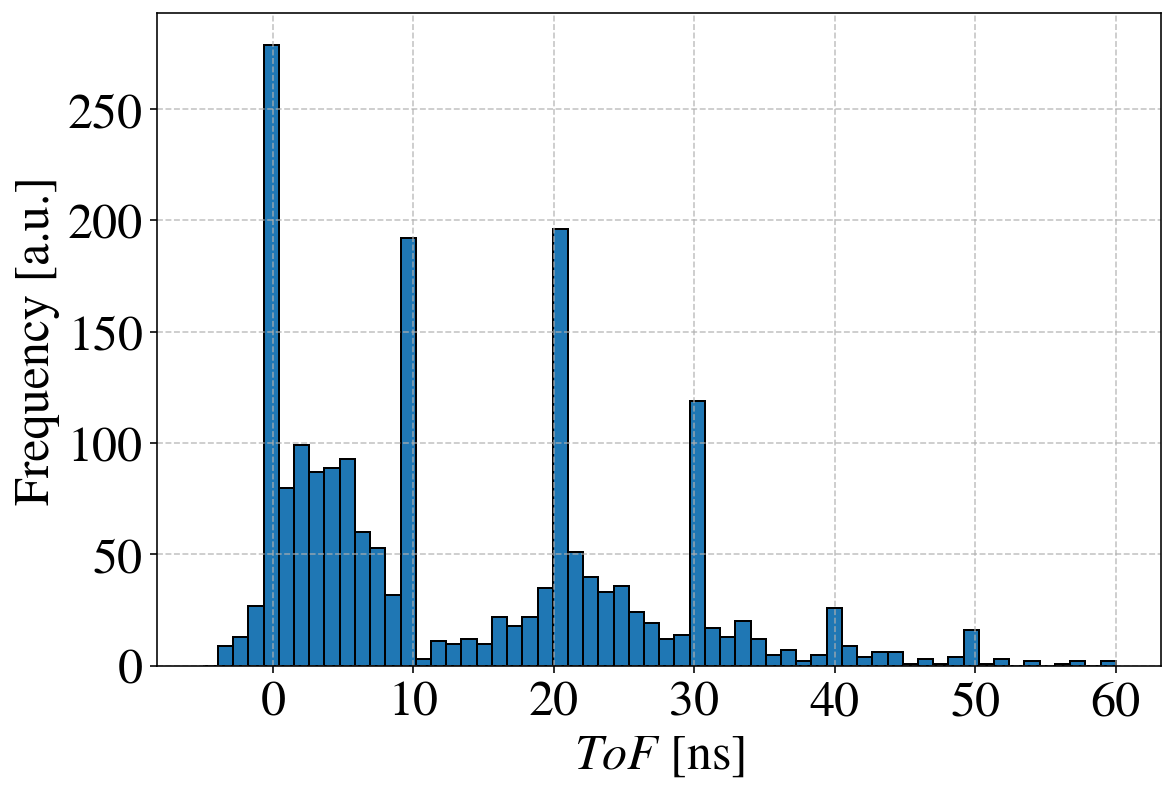

In [85]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1,1,1)
plt.hist(ToF, bins=bins,edgecolor='k')
# plt.hist(ToF_cleaned, bins=bins,edgecolor='k')#,bins=np.linspace(0,1e6,100));

set_axes( ax, '$ToF$ [ns]', 'Frequency [a.u.]', do_add_grid=True );#, xlim=(-10,150));
# ax.set_yscale('log');

### add expectation 

In [31]:
def Cf252_En_distribution( En ):
    # Amer. Jour. Physi. 81(2):112-119
    return np.exp(-0.88*En)*np.sinh(np.sqrt(2*En))


Ymax = np.max(Cf252_En_distribution( np.linspace(0, 10, 100) ));
def Sample_En( En_min = 0.0, En_max = 10.0 , NattemptMax=1000 ):#{
    # sample En from Cf252 distribution in [MeV]
    n = 1
    while n < NattemptMax:#{
        # sample En from a uniform distribution
        En = np.random.uniform(low=En_min, high=En_max)
        # sample Y from a uniform distribution up to Ymax
        Y  = np.random.uniform(low=0,      high=Ymax)
        # keep En if Y is below Cf distribution value for En
        if Y < Cf252_En_distribution( En ):#{
            return En
        #}        
        n = n+1;
    #}
    return -1;
#}

In [32]:
def plot_step_hist( x_arr, bins=np.linspace(0,1,10), label="", color='k', ScaleFactor=1,
                   density=False,capsize=2, capthick=2,marker='o',linewidth=2):
    h,edges = np.histogram( x_arr, bins=bins )
    h_err = np.sqrt(h)

    if density==True:
        h_err = h_err/np.sum(h)
        h     = h / np.sum(h)

    h     = h*ScaleFactor
    h_err = h_err*ScaleFactor
    x     = (edges[1:] + edges[:-1])/2
    x_err = (edges[1:] - edges[:-1])/2
    plt.step ( x, h, color=color, where='mid', label=None ) 
    plt.errorbar ( x=x, xerr=x_err, y=h, yerr=h_err, 
                  color=color, marker=marker, linestyle='None',label=label, 
                  capsize=capsize, capthick=capthick, linewidth=linewidth )
    return x,h,x_err,h_err

In [33]:
N = 50000
En = np.array([Sample_En() for i in range(N)])
En_min_arr = [0.8, 1.6, 2.4] # MeV
colors     = ['royalblue','salmon','forestgreen']
# En_min = 1.6 # MeV
# resolution smearing (source and detectors geometry, scintillation rise time, electronics and cabling) 
sigma = 3 # ns
## relative weights for gammas and neutrons 
## (not consistent with fission multiplicity, 
## because of the different detection efficiencies for neutrons and gammas)
NgammasAvg   = 3;
NneutronsAvg = 4;


expected_ToF_smeared = dict()
for En_min in En_min_arr:#{
    En_detectable = En[En > En_min]

    d   = 46    # cm
    c   = 30.   # cm/ns
    m_n = 939.656 # MeV/c2

    gamma_n = (En + m_n) / m_n
    beta_n  = np.sqrt(1 - 1./np.square(gamma_n))
    v_n     = beta_n * c
    ToF_n   = d / v_n

    gamma_n_detectable = (En_detectable + m_n) / m_n
    beta_n_detectable  = np.sqrt(1 - 1./np.square(gamma_n_detectable))
    v_n_detectable     = beta_n_detectable * c
    ToF_n_detectable   = d / v_n_detectable

    ToF_gamma_ns   = d / c
    
    ### Give relative weight to the $\gamma$ and neutrons according to their multiplicities from $^{252}$Cf fission
    # no need to be accurate here, only sort of
    ToF_gamma = ToF_gamma_ns * np.ones( int(NgammasAvg/NneutronsAvg * len(En)) )
    
    ToF_252Cf = np.concatenate([ToF_gamma,ToF_n_detectable])    
    
    #### smear the ToF to emulate finite resolution from scintillation and electronics
    #### and push gamma peak rightward from t=0, according to the smearing applied
    expected_ToF_smeared[En_min] = np.array([ np.random.normal(loc=ToF, scale=sigma) for ToF in ToF_252Cf])  + sigma    
#}
print('done.')

done.


### plot

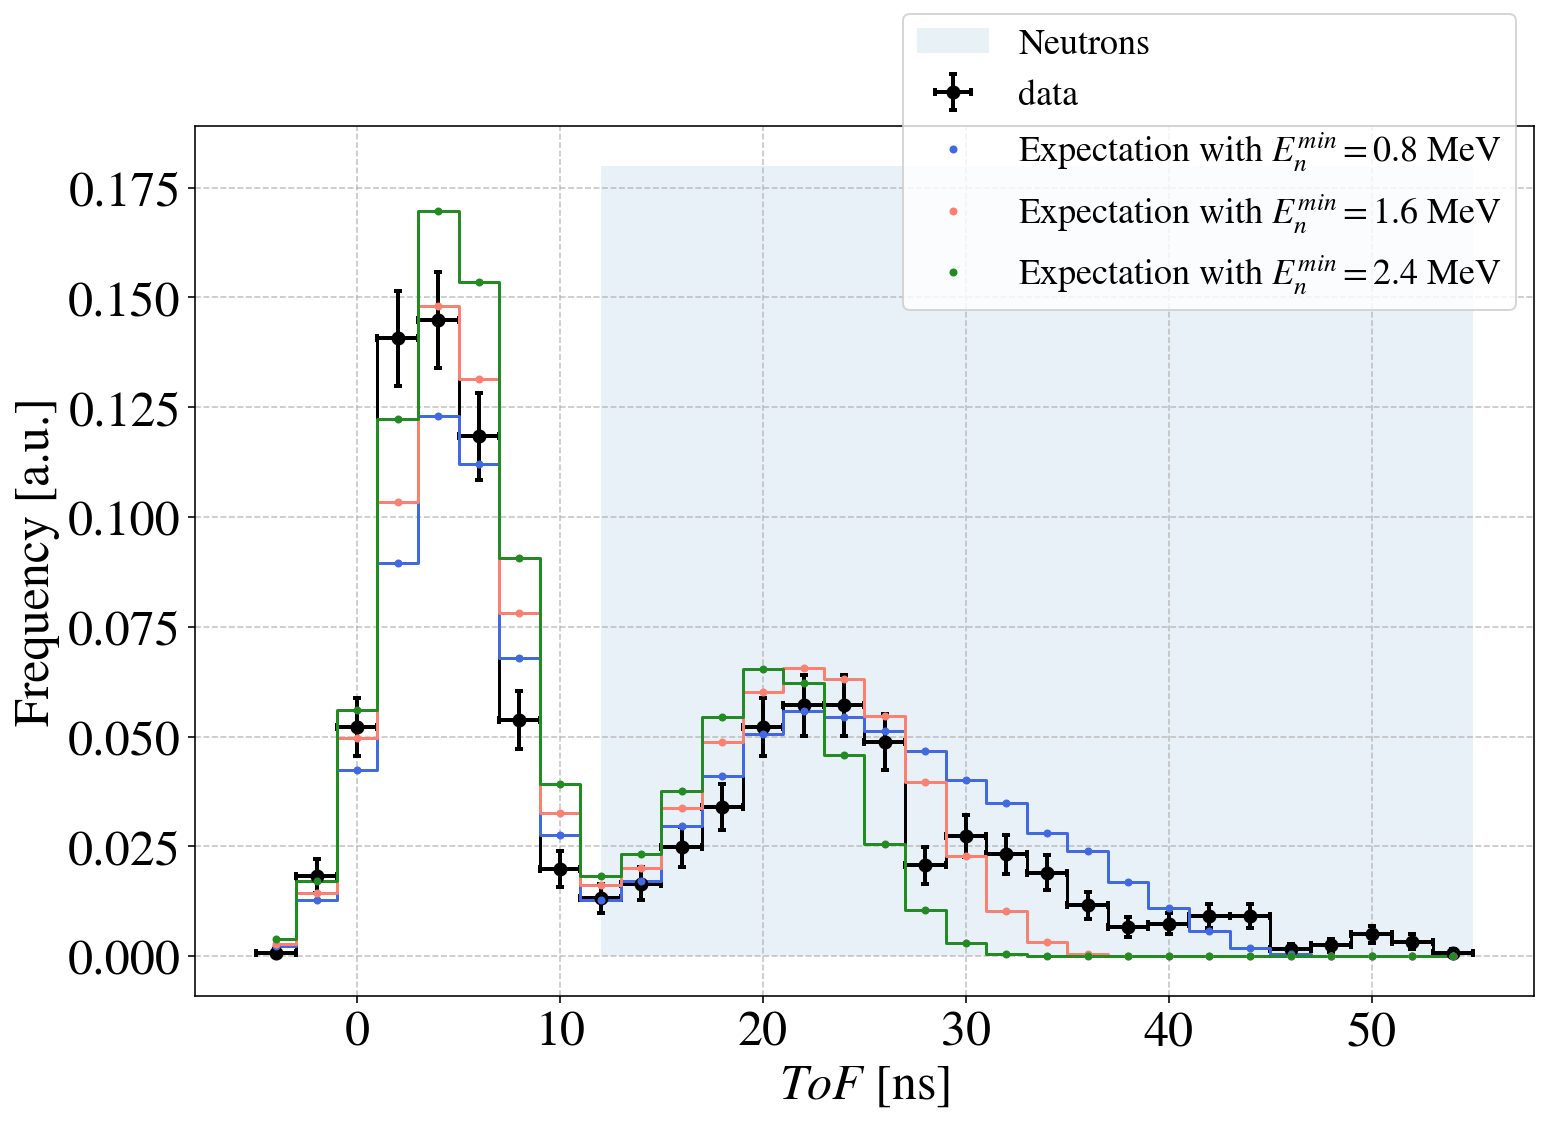

In [40]:
bins = np.linspace(-5,55,31) 

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
plot_step_hist( ToF, bins=bins, label="data", color='k', density=True)
# plot_step_hist( ToF_cleaned, bins=bins, label="data", color='k', density=True)
for En_min,color in zip(En_min_arr,colors):#{
    plot_step_hist( expected_ToF_smeared[En_min], bins=bins, 
                   label="Expectation with $E_n^{min}=%.1f$ MeV"%En_min, 
                   color=color, density=True, 
                   capthick=0, capsize=0,linewidth=0,
                   marker='.', 
                  )
ax.fill_between([12,55],[0,0],[np.max(ax.get_ylim()),np.max(ax.get_ylim())],alpha=0.1,label='Neutrons')
set_axes( ax, '$ToF$ [ns]', 'Frequency [a.u.]', do_add_grid=True, do_add_legend=True );#, xlim=(-10,150));
ax.legend(bbox_to_anchor=(1.,1.15),loc='best',fontsize=18);
# ax.set_yscale('log');

#### Plot energy deposit in the data (QDC)

In [169]:
ToF = np.array(events['SensL ToF']['ToF[ns]'])
QDC = np.array(events['SensL ToF']['QDC'])

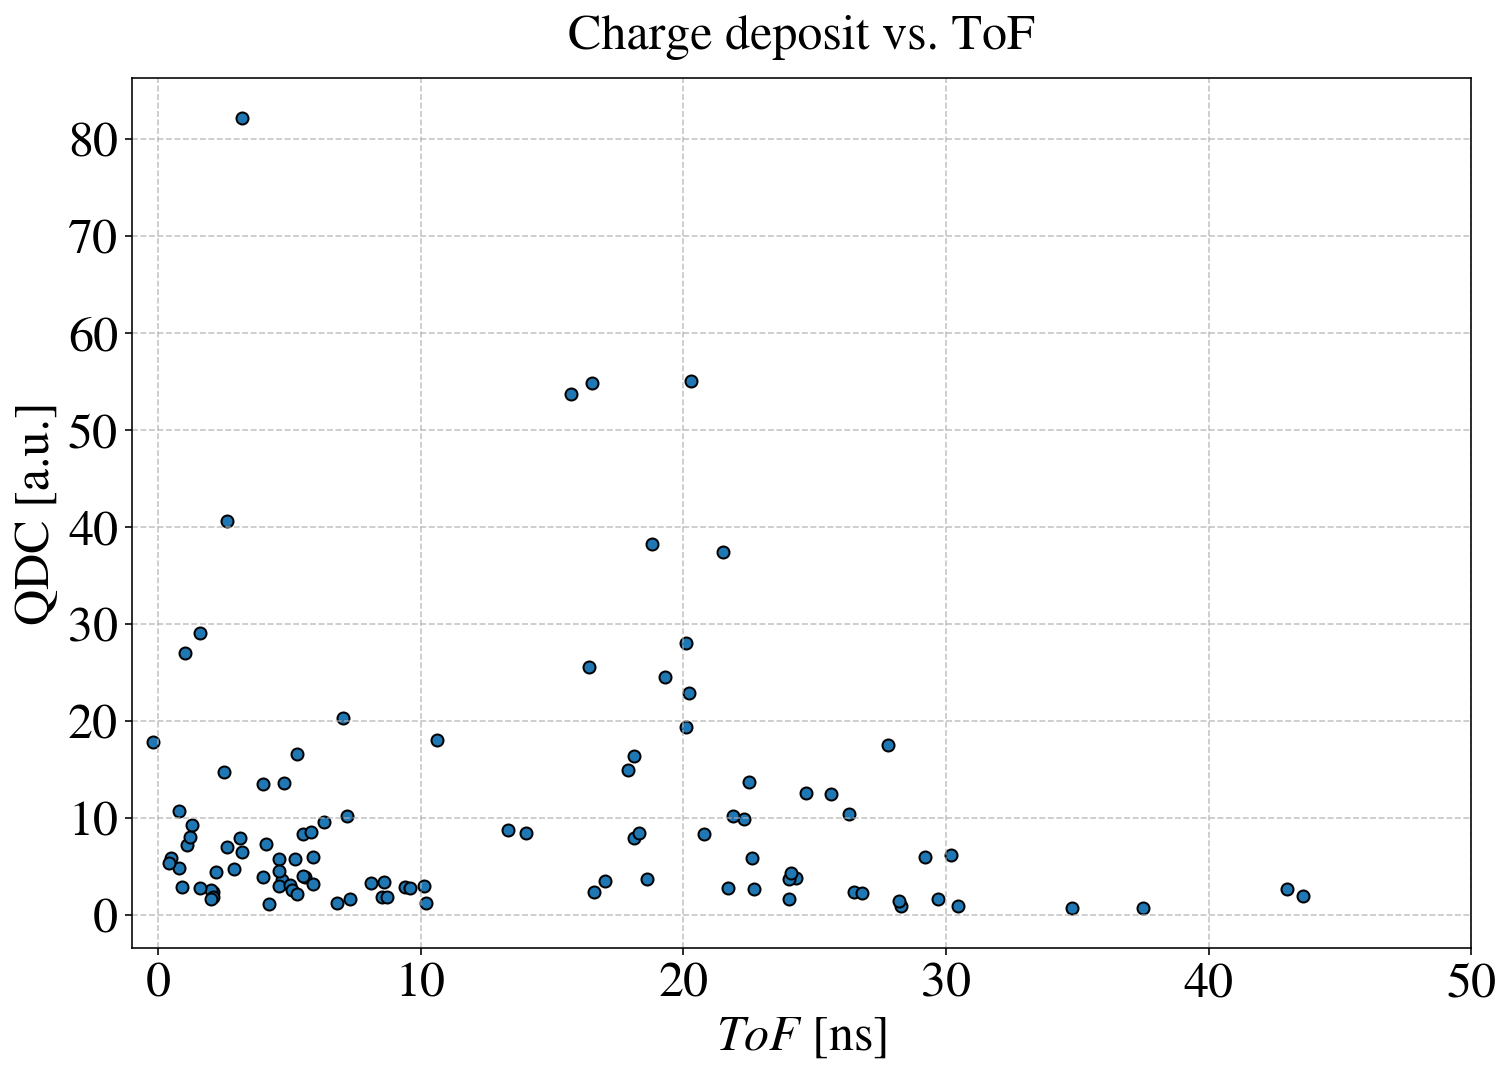

In [176]:

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
ax.scatter(ToF,QDC, edgecolor='k')
set_axes( ax, '$ToF$ [ns]', 'QDC [a.u.]', title='Charge deposit vs. ToF', do_add_grid=True, xlim=(-1,50));

# arxiv

In [30]:
# fdebug = 1
# # meas_label = 'background'
# # meas_label = 'Na22'
# meas_label = 'nToF_Cf252'

# Nevents   = 10000#len(events[meas_label])
# Ntriggers = 0
# events['SensL ToF'] = pd.DataFrame({})

# for ev1_idx in range(Nevents):#{
#     ev1   = events[meas_label][ev1_idx:ev1_idx+1]    
#     det1  = float(ev1['detector'])
#     t1_ns = float(ev1['time[ms]']*1.e6)
#     # print(det1,t1_ns)
    
#     if ((det1==KETEK_3) or (det1==KETEK_9)):
#         Ntriggers = Ntriggers+1
#         # Scan a few events forward (events are sorted in time)
#         # to see if there is an in the SensL detector 
#         # within a time window of 500 ns
#         for ev2_idx in range(ev1_idx+1,
#                              np.min([ev1_idx+2,Nevents])):#{

#             ev2   = events[meas_label][ev2_idx:ev2_idx+1]
#             det2  = float(ev2['detector'])
#             t2_ns = float(ev2['time[ms]']*1.e6)
#             QDC2  = float(ev2['Qtot[a.u.]'])

#             if ((det2==SensL_12) and (np.abs(t1_ns - t2_ns) < trigger_window_ns)):
                
#                 t_trigger     = t1_ns 
#                 t_SensL       = t2_ns
#                 ToF_ns        = t_SensL - t_trigger
#                 QDC_SensL     = QDC2


#                 events['SensL ToF'] = events['SensL ToF'].append(                
#                     pd.DataFrame({'det_trigger' :det1, 't_trigger[ns]':t_trigger, 't_SensL[ns]':t_SensL, 'ToF[ns]':ToF_ns, 'QDC':QDC_SensL,
#                          },index=[ev2_idx]))
                
#                 if fdebug>1: print('Measured ToF event:',
#                                      't_trigger = %.1f'%t_trigger,'ns',
#                                      'ToF = %.1f'%ToF_ns,'ns','QDC=%.1f'%QDC_SensL)

#         #}        
#     #}
#     if ev1_idx%(int(Nevents/10))==0: print('%.0f'%(100.*float(ev1_idx)/Nevents),'%')
# #}

# print('Done')
# print('Counted', Ntriggers,'trigger events in the two KETEK detectors','and',len(events['SensL ToF']),'ToF events')

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
Done
Counted 9787 trigger events in the two KETEK detectors and 4 ToF events


## Look for "triples" - trigger on both KETEK detectors and look for an event in the SensL one

In [90]:
fdebug = 1
# meas_label = 'background'
meas_label = 'nToF_Cf252'
# meas_label = 'Na22'
Nevents         = len(events[meas_label])
Ncoinc_triggers = 0
events['SensL ToF'] = pd.DataFrame({})

for ev1_idx in range(Nevents):#{
    ev1   = events[meas_label][ev1_idx:ev1_idx+1]    
    det1  = float(ev1['detector'])
    t1_ns = float(ev1['time[ms]']*1.e6)
    # print(det1,t1_ns)
    
    # look 5 events forward (events are sorted in time)
    # to see if there is a coincidence events in the two KETEK detector
    for ev2_idx in range(ev1_idx+1,
                         np.min([ev1_idx+5,Nevents])):#{

        ev2   = events[meas_label][ev2_idx:ev2_idx+1]
        det2  = float(ev2['detector'])
        t2_ns = float(ev2['time[ms]']*1.e6)

        if ( (det1*det2 == KETEK_3*KETEK_9) and (np.abs(t1_ns - t2_ns) < dt_ns) ): #{
            if fdebug>1: print('detectors',det1,'and',det2,
                               'saw events',ev1_idx,'and',ev2_idx,
                               'within %.1f'%np.abs(t1_ns - t2_ns),'ns')

            Ncoinc_triggers = Ncoinc_triggers+1
            
            # if trigger on the two KETEK detectors, 
            # look for a SensL event 3 events forward and backward            
            for ev3_idx in range(ev2_idx+1,
                                 np.min([ev2_idx+10,Nevents])):#{
                
                ev3   = events[meas_label][ev3_idx:ev3_idx+1]
                det3  = float(ev3['detector'])
                t3_ns = float(ev3['time[ms]']*1.e6)
                QDC3  = float(ev3['Qtot[a.u.]'])
                
                t_trigger     = (t1_ns+t2_ns)/2. 
                t_trigger_err = np.abs(t1_ns-t2_ns)/2. 
                t_SensL       = t3_ns
                ToF_ns        = t_SensL - t_trigger
                QDC_SensL     = QDC3

                if det3==SensL_12:
                    events['SensL ToF'] = events['SensL ToF'].append(
                        pd.DataFrame({'t_trigger[ns]':t_trigger,
                                      't_trigger_err[ns]':t_trigger_err,
                                      't_SensL[ns]':t_SensL,
                                      'ToF[ns]':ToF_ns,'QDC':QDC_SensL,
                                     },index=[ev3_idx]))
                    
                # print('det3=',det3,',t3_ns=',t3_ns)
                if (det3==SensL_12) and (ToF_ns<200): # { if its a SensL event, record it... 
                    
                    if fdebug: print('Measured ToF event:',
                                     't_trigger = %.1f'%t_trigger,'ns',
                                     'ToF = %.1f'%ToF_ns,'ns',
                                     'QDC=%.1f'%QDC_SensL)
                #}
        #}
        
    #}
    if ev1_idx%(int(Nevents/10))==0: print('%.0f'%(100.*float(ev1_idx)/Nevents),'%')
#}

print('Done')
print('Counted',
      Ncoinc_triggers,'coincidence trigger events in the two KETEK detectors',
     'and',len(events['SensL ToF']),'ToF events')

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
Measured ToF event: t_trigger = 97378317264.8 ns ToF = 16.1 ns QDC=8.4
100 %
Done
Counted 3647 coincidence trigger events in the two KETEK detectors and 801 ToF events


(array([59., 47., 48., 54., 53., 58., 53., 55., 56., 37., 46., 41., 34.,
        25., 30., 15., 19., 20., 18., 14.,  2.,  4.,  2.,  7.,  0.,  2.,
         0.,  1.,  0.,  1.]),
 array([1.61499939e+01, 4.38718190e+05, 8.77420230e+05, 1.31612227e+06,
        1.75482431e+06, 2.19352635e+06, 2.63222839e+06, 3.07093043e+06,
        3.50963247e+06, 3.94833451e+06, 4.38703655e+06, 4.82573859e+06,
        5.26444063e+06, 5.70314267e+06, 6.14184471e+06, 6.58054675e+06,
        7.01924879e+06, 7.45795083e+06, 7.89665287e+06, 8.33535491e+06,
        8.77405695e+06, 9.21275899e+06, 9.65146103e+06, 1.00901631e+07,
        1.05288651e+07, 1.09675672e+07, 1.14062692e+07, 1.18449712e+07,
        1.22836733e+07, 1.27223753e+07, 1.31610774e+07]),
 <BarContainer object of 30 artists>)

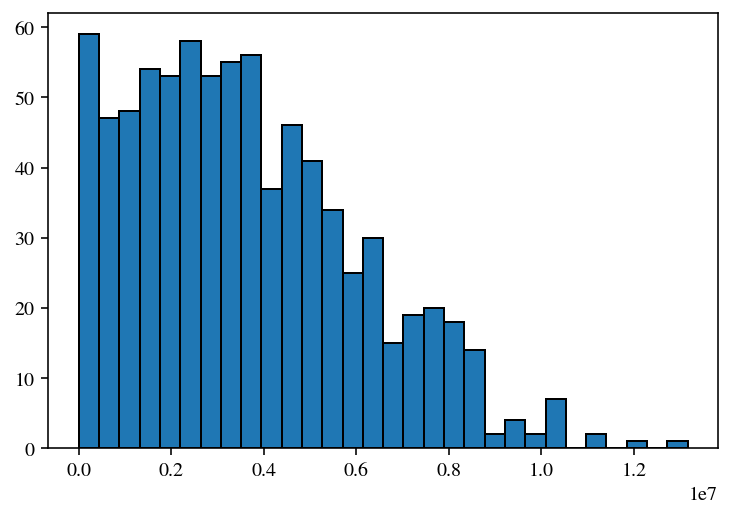

In [91]:
ToF = np.array(events['SensL ToF']['ToF[ns]'])
plt.hist(ToF,bins=30,edgecolor='k')#,bins=np.linspace(0,1e6,100));

In [94]:
t=events['SensL ToF']['t_trigger[ns]']
np.max(t)/1e9


100.6954931815

In [44]:
Nevents/10

1409.0

In [45]:
ev1_idx

38